<a href="https://colab.research.google.com/github/santacruzAI/MLPhasesOfMatter/blob/main/%5DMachine_Learning_Phase_Transitions_Implementation_5.0.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [1]:
import numpy as np
import random
!pip install numba
from numba import jit

# **Data Generation**

In [2]:
#Generate random grids of 1s and -1s, making sure they are unbalanced. Then calculate the energy of the current state. 
#Then pick a random particle in the lattice, and flip its sign. When you flip the spin, you have to calculate the energy of this new state again. 
#If it is less than the current energy, switch curr state to new state. If greater, apply the probability e^-(beta)(Ev-E_mu) = e^-(beta)(J)(summation of the product between the 
#flipped particle and its neighbors).
#Sample for many different temps
@jit
def get_energy(lattice):
  en = 0
  #Brute Neighbor Addition
  for i in range(len(lattice)):
    for j in range(len(lattice)):
      if i>0:
        en -= lattice[i][j]*lattice[i-1][j]
      if i<len(lattice)-1:
        en -= lattice[i][j]*lattice[i+1][j]
      if j>0:
        en -= lattice[i][j]*lattice[i][j-1]
      if j<len(lattice)-1:
        en -= lattice[i][j] * lattice[i][j+1]
  return en

grid_size = 40 #The grid size.
starts = 10 #For each temperature. 10
samples = 100 #The number of samples per start per temperature. 100
temp_range = np.linspace(1,3.7,27) #The range of temperatures from 1 to 3.7
therm_steps = 100 #100
tempList = []
sampleList = []
k = (1.38064852)/(10**23)
#b = 0.7 #This is our beta*J value. b = 1/kT
count = 0
total = 0
loopCount = 0
for temp in temp_range:
  b = 1/(k*temp)
  for start in range(starts):
    for sample in range(samples):
      loopCount+=1
      start_lat = np.array([[np.random.exponential() for a in range(grid_size)] for count2 in range(grid_size)])
      lattice = np.zeros((grid_size,grid_size))
      lattice[start_lat>=0.4] = 1.0
      lattice[start_lat<0.4] = -1.0
      if list(lattice.flatten()).count(1.)/(grid_size**2) > 0.5:
        count+=1#To ensure largely unbalanced  
        total += 1
      else:
        total += 1
      enList = []
      timeList = []
      time = 0  
      for therm_step in range(therm_steps):
        curr_en = get_energy(lattice)
        flip_x,flip_y = (random.randint(0,grid_size-1),random.randint(0,grid_size-1))
        state_v = lattice.copy()
        state_v[flip_x][flip_y] *=-1
        v_en = get_energy(state_v)
        p_uv = 1 if v_en<curr_en else np.exp(-b*(v_en - curr_en))
        timeList.append(time)
        time += 1
        if np.random.random()<p_uv:
          lattice = state_v.copy()
        enList.append(get_energy(lattice))
      sampleList.append(lattice)
      tempList.append(temp)
len(sampleList), loopCount

(27000, 27000)

In [3]:
sampleList

[array([[-1., -1., -1., ...,  1., -1.,  1.],
        [ 1., -1.,  1., ..., -1., -1.,  1.],
        [ 1.,  1.,  1., ...,  1., -1., -1.],
        ...,
        [-1.,  1.,  1., ...,  1.,  1.,  1.],
        [ 1.,  1.,  1., ..., -1.,  1.,  1.],
        [ 1.,  1.,  1., ...,  1.,  1.,  1.]]),
 array([[ 1.,  1.,  1., ...,  1.,  1.,  1.],
        [ 1., -1., -1., ..., -1.,  1.,  1.],
        [-1.,  1.,  1., ...,  1.,  1.,  1.],
        ...,
        [-1.,  1.,  1., ..., -1., -1., -1.],
        [ 1.,  1.,  1., ...,  1.,  1., -1.],
        [-1.,  1., -1., ..., -1.,  1.,  1.]]),
 array([[-1., -1.,  1., ..., -1., -1.,  1.],
        [-1., -1.,  1., ...,  1., -1.,  1.],
        [ 1., -1.,  1., ...,  1., -1., -1.],
        ...,
        [-1.,  1., -1., ...,  1., -1., -1.],
        [ 1.,  1., -1., ...,  1.,  1.,  1.],
        [ 1., -1.,  1., ..., -1., -1.,  1.]]),
 array([[ 1., -1., -1., ..., -1.,  1., -1.],
        [ 1., -1., -1., ..., -1.,  1.,  1.],
        [ 1.,  1., -1., ..., -1.,  1., -1.],
        ..

1.0

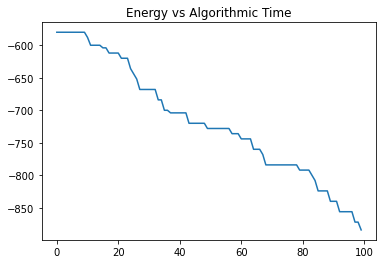

In [4]:
import matplotlib.pyplot as plt
plt.plot(timeList,enList)
plt.title("Energy vs Algorithmic Time")
count/total

## **Data Preprocessing**

In [5]:
feature_matrix = np.array([features.flatten() for features in sampleList]) #Flatten lattice
np.random.shuffle(feature_matrix) #
end = 2 * len(feature_matrix) // 5
feature_train_matrix = feature_matrix[:-1*end]
feature_test_matrix = feature_matrix[-1*end:]
tempList2 = np.array([[temp] for temp in tempList])
tempList2_train = tempList2[:-1*end]
tempList2_test = tempList2[-1*end:]
Tc = 2.27
y_train = tempList2_train.copy()
y_train[tempList2_train>=Tc] = 1
y_train[tempList2_train<Tc] = 0
y_test = tempList2_test.copy()
y_test[tempList2_test>=Tc] = 1
y_test[tempList2_test<Tc] = 0
# from sklearn.linear_model import LogisticRegression
# logReg = LogisticRegression()
# model = logReg.fit(feature_train_matrix,y_train)
# y_pred = model.predict(feature_test_matrix)
# from sklearn.metrics import accuracy_score, classification_report
# print(accuracy_score(y_pred,y_test))

## **Feedforward Neural Network for Lattice Phase Transitions**

In [6]:
import torch.nn as nn #Super-class for PyTorch NNs
from torch.nn import Sigmoid
from torch.optim import Adam
import torch
from torch import Tensor
from torch import from_numpy

class LinearModel(nn.Module): 
    def __init__(self): #Define struct
        super(LinearModel, self).__init__()          
        self.fc_1 = nn.Linear(grid_size*grid_size, 100)    
        self.fc_2 = nn.Linear(100, 2)    
            
    def forward(self, X):    
        #output = self.norm(X)
        output = self.fc_1(X)
        output = nn.Sigmoid()(output)
        output = self.fc_2(output)
        output = nn.Sigmoid()(output)
        return output

EPOCHS = 100

model = LinearModel()
model.train()
criterion = nn.CrossEntropyLoss()
optimizer = Adam(model.parameters())
y_train = torch.from_numpy(y_train)
y_train = y_train.type(torch.LongTensor)
feature_train_matrix = torch.from_numpy(feature_train_matrix)#.type(torch.DoubleTensor)
#print(np.shape(feature_train_matrix))

for ep in range(EPOCHS):
  acc = 0
  for i in range(len(y_train)):
    feature = feature_train_matrix[i:i+1].type(torch.FloatTensor)
    optimizer.zero_grad()
    out = model(feature)
    label = y_train[i][0].unsqueeze(0)
    #print(label,out)
    if(label.item()==out.argmax().item()):
      acc+=1
    loss = criterion(out,label)
    loss.backward()
    optimizer.step()
  print("EPOCH",ep,"loss: ",round(loss.item(),2))
  print("Accuracy:",acc/len(y_train))  

EPOCH 0 loss:  0.31
Accuracy: 0.9576543209876544
EPOCH 1 loss:  0.31
Accuracy: 0.9205555555555556
EPOCH 2 loss:  0.31
Accuracy: 0.9081481481481481
EPOCH 3 loss:  0.31
Accuracy: 0.9229012345679012
EPOCH 4 loss:  0.31
Accuracy: 0.9275925925925926
EPOCH 5 loss:  0.31
Accuracy: 0.9343827160493827
EPOCH 6 loss:  0.31
Accuracy: 0.9404938271604938
EPOCH 7 loss:  0.31
Accuracy: 0.9382716049382716
EPOCH 8 loss:  0.31
Accuracy: 0.9489506172839506
EPOCH 9 loss:  0.31
Accuracy: 0.9445061728395062
EPOCH 10 loss:  0.31
Accuracy: 0.9639506172839506
EPOCH 11 loss:  0.31
Accuracy: 0.952716049382716
EPOCH 12 loss:  0.31
Accuracy: 0.9639506172839506
EPOCH 13 loss:  0.31
Accuracy: 0.957283950617284
EPOCH 14 loss:  0.31
Accuracy: 0.9587037037037037
EPOCH 15 loss:  0.31
Accuracy: 0.9632716049382716
EPOCH 16 loss:  0.31
Accuracy: 0.9624691358024692
EPOCH 17 loss:  0.31
Accuracy: 0.9662962962962963
EPOCH 18 loss:  0.31
Accuracy: 0.9662962962962963
EPOCH 19 loss:  0.31
Accuracy: 0.9667901234567902
EPOCH 20 los

In [7]:
y_test = torch.from_numpy(y_test)
y_test = y_test.type(torch.LongTensor)
feature_test_matrix = torch.from_numpy(feature_test_matrix)#.type(torch.DoubleTensor)
acc = 0
for i in range(len(y_test)):
    feature = feature_test_matrix[i:i+1].type(torch.FloatTensor)
    out = model(feature)
    label = y_test[i][0].unsqueeze(0)
    #print(label,out)
    if(label.item()==out.argmax().item()):
      acc+=1
    loss = criterion(out,label)
#print(loss)
print(acc/len(y_test))

0.9878703703703704


In [ ]:
EPOCHS = 100
from torch.optim import LBFGS
model = LinearModel()
model.train()
criterion = nn.CrossEntropyLoss()
optimizer = LBFGS(model.parameters(), lr = 0.01)
#y_train = torch.from_numpy(y_train)
#y_train = y_train.type(torch.LongTensor)
#feature_train_matrix = torch.from_numpy(feature_train_matrix)#.type(torch.DoubleTensor)
#print(np.shape(feature_train_matrix))

for ep in range(EPOCHS):
  acc = 0
  for i in range(len(y_train)):
    feature = feature_train_matrix[i:i+1].type(torch.FloatTensor)
    optimizer.zero_grad()
    out = model(feature)
    label = y_train[i][0].unsqueeze(0)
    #print(label,out)
    if(label.item()==out.argmax().item()):
      acc+=1
    loss = criterion(out,label)
    loss.backward()
    optimizer.step()
  print("EPOCH",ep,"loss: ",round(loss.item(),2))
  print("Accuracy:",acc/len(y_train))  

In [ ]:
y_test = torch.from_numpy(y_test)
y_test = y_test.type(torch.LongTensor)
feature_test_matrix = torch.from_numpy(feature_test_matrix)#.type(torch.DoubleTensor)
acc = 0
for i in range(len(y_test)):
    feature = feature_test_matrix[i:i+1].type(torch.FloatTensor)
    out = model(feature)
    label = y_test[i][0].unsqueeze(0)
    #print(label,out)
    if(label.item()==out.argmax().item()):
      acc+=1
    loss = criterion(out,label)
#print(loss)
print(acc/len(y_test))